In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch

from model import *

# Data Generation

In [3]:
num_mentors = 200
num_mentees = 500
num_matches = 1000
num_features = 20
num_truth = 100

mentee_truth = np.random.rand(num_mentees, num_truth)
mentor_truth = np.random.rand(num_mentors, num_truth)
feature_transform = np.random.rand(num_truth, num_features)

mentee_features = mentee_truth @ feature_transform
mentor_features = mentor_truth @ feature_transform
matches = np.random.randint([num_mentors, num_mentees], size=(num_matches, 2))
matches_outcome = np.array([
    np.sum(mentor_truth[id1] * mentee_truth[id2])
    / (np.linalg.norm(mentor_truth[id1]) * np.linalg.norm(mentee_truth[id2]))
    for id1, id2 in matches])

In [4]:
matches = torch.Tensor(matches).int()
matches_outcome = torch.Tensor(matches_outcome).float()

# Model Creation

In [5]:
gen_model = EmbeddingGenerationModel(num_mentors, num_mentees)
gen_optimizer = torch.optim.AdamW(gen_model.parameters())
gen_criterion = nn.MSELoss()

In [6]:
epochs = 1000
batches = 20
batch_size = int(len(matches)/batches)

In [7]:
gen_model.train()
for epoch in range(epochs):
    for _ in range(batches):
        idx = np.random.choice(range(len(matches)), batch_size, replace=False)
        gen_optimizer.zero_grad()
        input_data = torch.t(matches[idx])
        logits = gen_model(*input_data)
        loss = gen_criterion(logits, matches_outcome[idx])
        loss.backward()
        gen_optimizer.step()
    if epoch % 100 == 0:
        print(loss)
gen_model.eval();

tensor(0.5389, grad_fn=<MseLossBackward0>)
tensor(0.2104, grad_fn=<MseLossBackward0>)
tensor(0.0767, grad_fn=<MseLossBackward0>)
tensor(0.0147, grad_fn=<MseLossBackward0>)
tensor(0.0055, grad_fn=<MseLossBackward0>)
tensor(0.0020, grad_fn=<MseLossBackward0>)
tensor(0.0004, grad_fn=<MseLossBackward0>)
tensor(4.9948e-06, grad_fn=<MseLossBackward0>)
tensor(4.7703e-06, grad_fn=<MseLossBackward0>)
tensor(4.0036e-06, grad_fn=<MseLossBackward0>)


In [8]:
inf_model = EmbeddingInferenceModel(num_features)
inf_optimizer = torch.optim.AdamW(inf_model.parameters())
inf_criterion = nn.MSELoss()

In [9]:
epochs = 1000
batches = 20
batch_size = int(num_mentees/batches)

In [10]:
inf_model.train()
for epoch in range(epochs):
    for _ in range(batches):
        idx = np.random.choice(range(num_mentees), batch_size, replace=False)
        inf_optimizer.zero_grad()
        input_data = torch.Tensor(mentee_features[idx])
        logits = inf_model(input_data)
        true = gen_model.mentees(torch.Tensor(idx).int()).detach()
        loss = inf_criterion(logits, true)
        loss.backward()
        inf_optimizer.step()
    if epoch % 100 == 0:
        print(loss)
inf_model.eval();

tensor(1.4341, grad_fn=<MseLossBackward0>)
tensor(0.3797, grad_fn=<MseLossBackward0>)
tensor(0.3205, grad_fn=<MseLossBackward0>)
tensor(0.3958, grad_fn=<MseLossBackward0>)
tensor(0.2381, grad_fn=<MseLossBackward0>)
tensor(0.3696, grad_fn=<MseLossBackward0>)
tensor(0.2427, grad_fn=<MseLossBackward0>)
tensor(0.3410, grad_fn=<MseLossBackward0>)
tensor(0.3574, grad_fn=<MseLossBackward0>)
tensor(0.2769, grad_fn=<MseLossBackward0>)


# Evaluation

In [11]:
input_data = torch.t(matches)
predicted = gen_model(*input_data).detach().cpu().numpy()
actual = matches_outcome

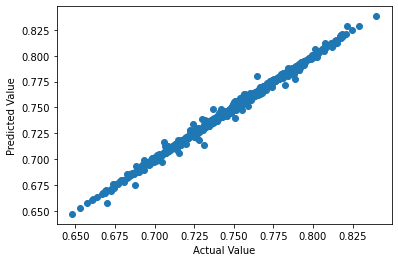

In [12]:
plt.scatter(actual, predicted)
plt.xlabel('Actual Value')
plt.ylabel('Predicted Value');

In [13]:
feature = 0
input_data = torch.Tensor(mentee_features)
predicted = inf_model(input_data).detach().cpu().numpy()
actual = gen_model.mentees(torch.Tensor(range(num_mentees)).int()).detach().cpu().numpy()
predicted, actual = predicted[:, feature], actual[:, feature]

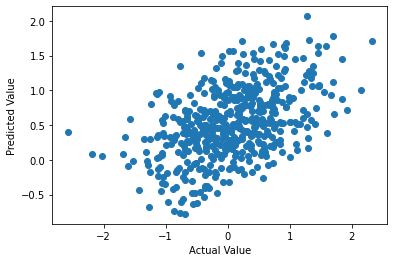

In [14]:
plt.scatter(actual, predicted)
plt.xlabel('Actual Value')
plt.ylabel('Predicted Value');